# "Pump it Up: Data Mining the Water Table"

EDA

Jason & Tom

In [1]:
# Imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# EDA

This notebook explains the steps we took while performing EDA on our cleaned dataset. Whilst EDA does technically include 'data cleaning', we took the initiative to place that in it's own notebook so that the steps we took are much clearer. This notebook will present our findings on the correlation between certain features, as well as feature selection / engineering.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [2]:
df = pd.read_csv("./datasets/cleaned_water.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

# 1 Graphing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           59400 non-null  int64  
 1   amount_tsh                   59400 non-null  float64
 2   date_recorded                59400 non-null  object 
 3   funder                       55765 non-null  object 
 4   gps_height                   59400 non-null  int64  
 5   installer                    55745 non-null  object 
 6   longitude                    59400 non-null  float64
 7   latitude                     59400 non-null  float64
 8   wpt_name                     59400 non-null  object 
 9   num_private                  59400 non-null  int64  
 10  basin                        59400 non-null  int64  
 11  subvillage                   59029 non-null  object 
 12  region                       59400 non-null  object 
 13  region_code     

### 1.1 Correlation Matrix

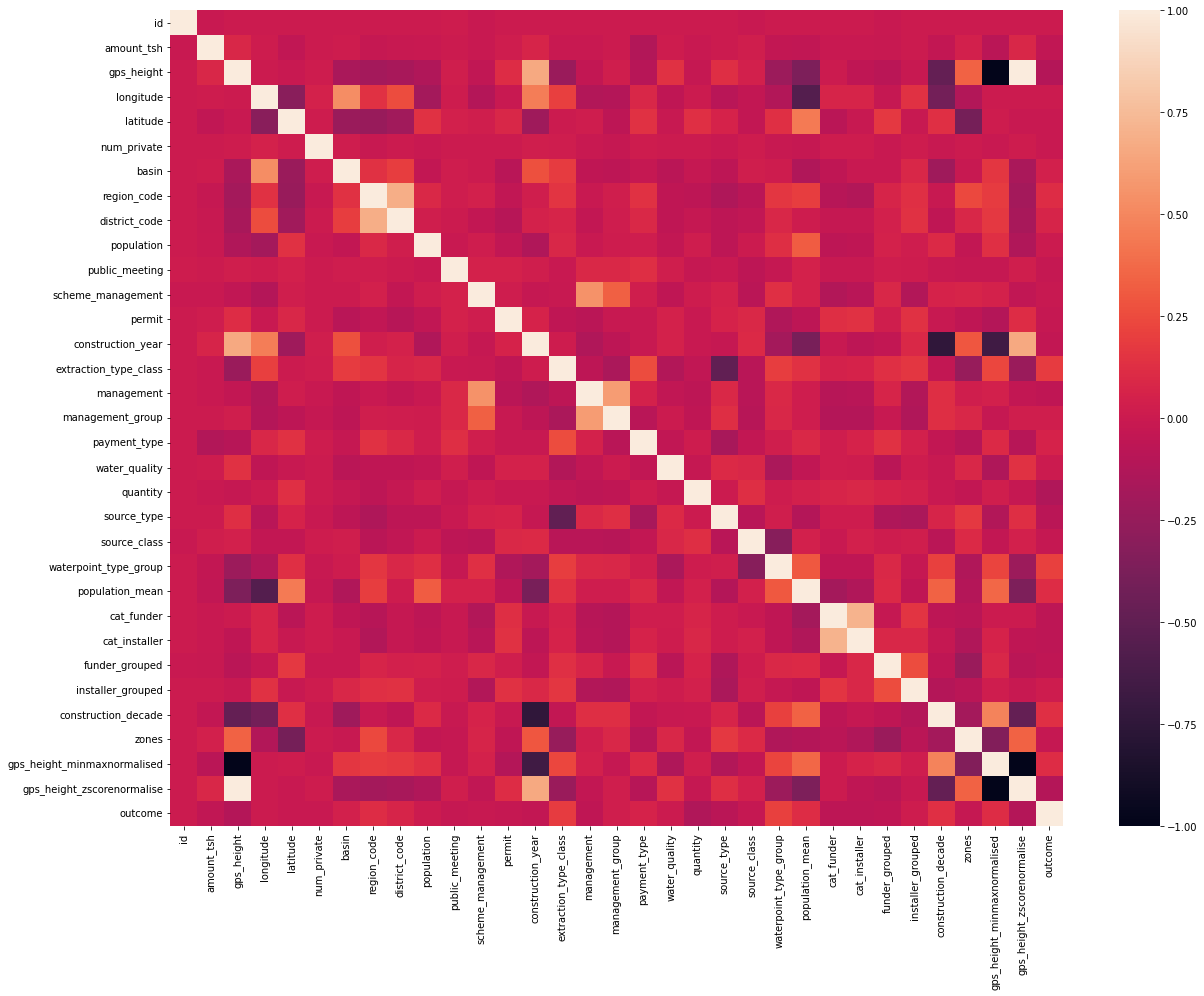

In [4]:
# Author [Jason]

# Correlation Matrix
plt.figure(figsize=(20,15))
matrix = df.corr().round(2)
sns.heatmap(matrix)
plt.show()

There's not many super highly correlated features.

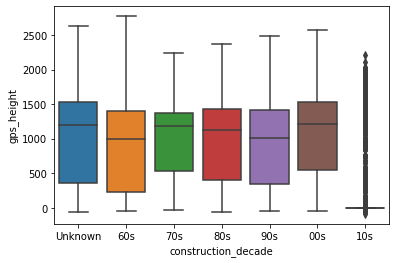

In [5]:
ax = sns.boxplot(data=df, x='construction_decade', y='gps_height')
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

There doesn't seem to be a significant change in decade and gps_height.
Add more to here if we want to test out any other correlations between features.

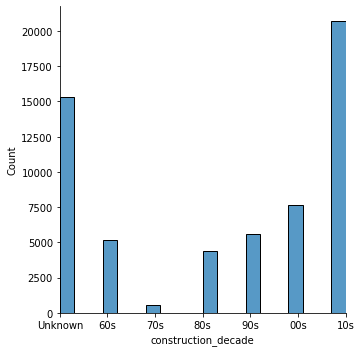

In [6]:
ax = sns.displot(data=df, x='construction_decade')
plt.xlim(0,6)
ax.set_xticklabels(['Unknown', '60s', '70s', '80s', '90s', '00s', '10s'])
plt.show()

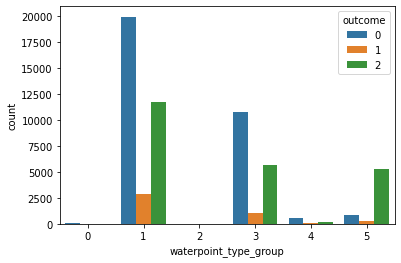

In [7]:
sns.countplot(x='waterpoint_type_group', hue='outcome', data=df)
plt.show()

Here, we can see that waterpoint_type_group 5 has a lot more of category 2, although this could be due to limited data.

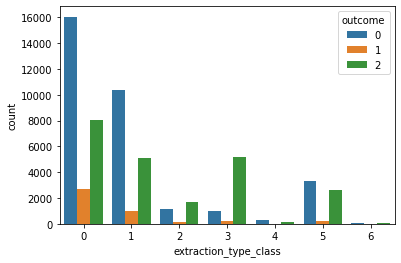

In [8]:
sns.countplot(x='extraction_type_class', hue='outcome', data=df)
plt.show()

Again, we can see that certain classes of extraction types are more likely to be of category 2.

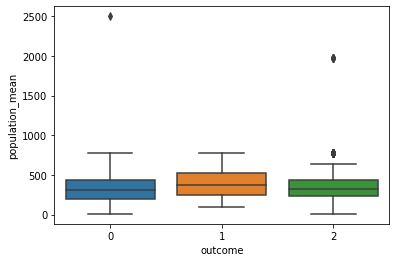

In [9]:
sns.boxplot(x='outcome', y='population_mean', data=df)
plt.show()

It's not crazy significant, but faulty wells usually have a larger population.

# 2 Feature Engineering

In [10]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['recorded_year'] = pd.DatetimeIndex(df ['date_recorded']).year
df['age'] = df['recorded_year'] - df['construction_year']
df['age'] = df['age'].apply(lambda x: x if x < 100 else -1)
df = df.drop('recorded_year',axis=1)

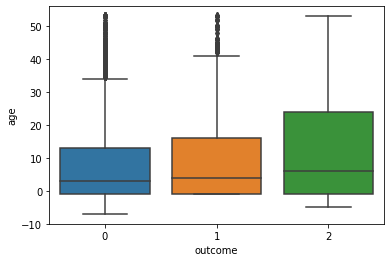

In [11]:
sns.boxplot(x='outcome', y='age', data=df)
plt.show()

In [12]:
# From here: https://github.com/BrendaLoznik/waterpumps

df['month'] = pd.DatetimeIndex(df['date_recorded']).month

# season encoder
# 1: 'short dry', 2: 'long rain', 3: 'long dry', 4: 'short rain'
season_mapper = {1: 1,2: 1, 3: 2, 4: 2, 5: 2, 6: 3, 7: 3,
                 8: 3, 9: 3, 10: 3, 11: 4, 12: 4}
#.p feature values to scale
df['season']=df['month'].replace(season_mapper)
df=df.drop('month', axis=1)

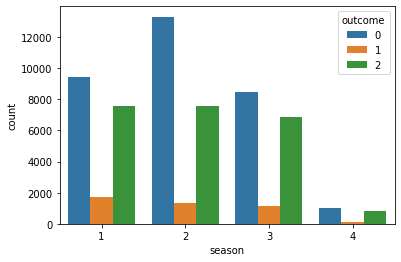

In [13]:
sns.countplot(x='season', hue='outcome', data=df)
plt.show()

In [14]:
# Author [Tom]

# quantity = 1 (enough) se to 1, everything else set to 0
df['consistent_water'] = np.where(df['quantity'] == 1, 1, 0)

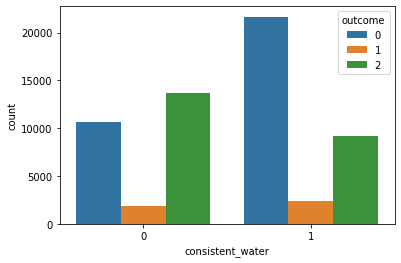

In [15]:
sns.countplot(x='consistent_water', hue='outcome', data=df)
plt.show()

In [16]:
# Author [Tom]

df['source_below_sea_level'] = np.where(df['gps_height'] < df['amount_tsh'], 1, 0)

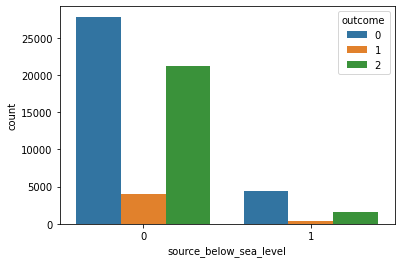

In [17]:
sns.countplot(x='source_below_sea_level', hue='outcome', data=df)
plt.show()

In [18]:
df.to_csv('./datasets/water_fe.csv')

# 3 Feature Importance

## 3.1 Random Forest

In [19]:
df_test = df.drop(columns = ['id', 'date_recorded', 'wpt_name','num_private','subvillage','region_code','district_code','lga','ward','recorded_by',
                            'scheme_name','extraction_type','extraction_type_group','payment','quality_group','quantity_group',
                            'source','waterpoint_type','status_group','construction_year','region','funder','installer'])

In [20]:
# Author [Jason]

target = df_test['outcome']
features = df_test.drop(columns=['outcome'])
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier()

Text(0.5, 0, 'Random Forest Feature Importance')

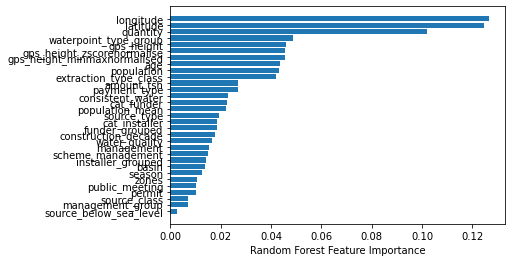

In [21]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")